In [2]:
import sys
import os
import time

sys.path.append(os.path.abspath("../.."))

### Test 1


In [ ]:
from primeGraph.graph.executable import Graph
from primeGraph.models.state import GraphState
from primeGraph.buffer.factory import History, LastValue
from primeGraph.checkpoint.storage.local_storage import LocalStorage
from primeGraph.constants import START, END
from typing import Dict


# Define our state model
class ProcessState(GraphState):
    status: LastValue[str]
    results: History[Dict[str, float]]


# Initialize state and graph with local storage and chain_id
chain_id = "process_workflow_v1"
state = ProcessState(status="", results={})
storage = LocalStorage()
graph = Graph(state=state, checkpoint_storage=storage, chain_id=chain_id)


# Define processing nodes
@graph.node()
def initialize_process(state):
    time.sleep(0.5)  # Simulate work
    return {"status": "initializing"}


@graph.node()
def process_data_1(state):
    time.sleep(0.5)  # Simulate work
    return {"status": "processing_1", "results": {"accuracy": 0.85, "step": 1.0}}


@graph.node(interrupt="after")
def process_data_2(state):
    time.sleep(0.5)  # Simulate work
    return {"status": "processing_2", "results": {"accuracy": 0.92, "step": 2.0}}


@graph.node()
def finalize(state):
    time.sleep(0.5)  # Simulate work
    return {"status": "completed"}


# Create the workflow
graph.add_edge(START, "initialize_process")
graph.add_edge("initialize_process", "process_data_1")
graph.add_edge("process_data_1", "process_data_2")
graph.add_edge("process_data_2", "finalize")
graph.add_edge("finalize", END)

# Compile and execute
graph.compile()
graph.visualize()

In [ ]:
graph.execute()

In [ ]:
storage.list_checkpoints(chain_id)

graph.checkpoint_storage.list_checkpoints(chain_id)

In [ ]:
storage.list_checkpoints(chain_id)

### Test 2 (LocalStorage)


DEBUG:graphviz._tools:deprecate positional args: graphviz.backend.piping.pipe(['renderer', 'formatter', 'neato_no_op', 'quiet'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.backend.rendering.render(['renderer', 'formatter', 'neato_no_op', 'quiet'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.backend.unflattening.unflatten(['stagger', 'fanout', 'chain', 'encoding'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.backend.viewing.view(['quiet'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.quoting.quote(['is_html_string', 'is_valid_id', 'dot_keywords', 'endswith_odd_number_of_backslashes', 'escape_unescaped_quotes'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.quoting.a_list(['kwargs', 'attributes'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.quoting.attr_list(['kwargs', 'attributes'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.dot.Dot.clear(['keep_attrs'])
DEBUG:graphviz._tools:deprecate posit

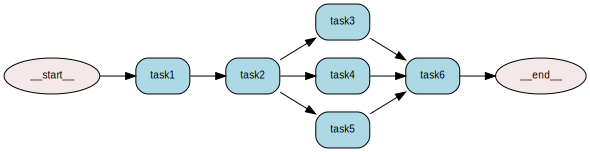

In [3]:
from primeGraph.models.state import GraphState
from primeGraph.buffer.factory import History
from primeGraph.checkpoint.local_storage import LocalStorage
from primeGraph.graph.executable import Graph
from primeGraph.constants import START, END


class StateForTestWithHistory(GraphState):
    execution_order: History[str]


state = StateForTestWithHistory(execution_order=[])
storage = LocalStorage()
graph = Graph(state=state, checkpoint_storage=storage)


@graph.node()
def task1(state):
    print("task1")
    time.sleep(0.5)
    return {"execution_order": "task1"}


@graph.node()
def task2(state):
    print("task2")
    time.sleep(0.5)
    return {"execution_order": "task2"}


@graph.node()
def task3(state):
    print("task3")
    time.sleep(1)
    return {"execution_order": "task3"}


@graph.node()
def task4(state):
    print("task4")
    time.sleep(2)
    print("task4 done")

    return {"execution_order": "task4"}


@graph.node()
def task5(state):
    print("task5")
    time.sleep(1)
    return {"execution_order": "task5"}


@graph.node(interrupt="before")
def task6(state):
    print("task6")
    return {"execution_order": "task6"}


graph.add_edge(START, "task1")
graph.add_edge("task1", "task2")
graph.add_edge("task2", "task3")
graph.add_edge("task2", "task4")
graph.add_edge("task2", "task5")
graph.add_edge("task4", "task6")
graph.add_edge("task3", "task6")
graph.add_edge("task5", "task6")
graph.add_edge("task6", END)
graph.compile()

graph.visualize()

In [4]:
chain_id = graph.start()
print(chain_id)
assert all(
    task in graph.state.execution_order
    for task in ["task1", "task2", "task3", "task4", "task5"]
), "tasks are not in there"
assert len(storage.list_checkpoints(graph.chain_id)) == 4  # n + 1 due to interrupt

DEBUG:primeGraph.graph.executable:Chain status updated to: ChainStatus.RUNNING


task1


INFO:primeGraph.checkpoint.local_storage:Checkpoint 'checkpoint_f90c3657-8aec-4218-8162-d6cc4740e393' saved in memory.
DEBUG:primeGraph.graph.executable:Checkpoint saved after node: task1


task2


INFO:primeGraph.checkpoint.local_storage:Checkpoint 'checkpoint_4f793195-6c02-4ab8-972b-33197ba93e24' saved in memory.
DEBUG:primeGraph.graph.executable:Checkpoint saved after node: task2


task4task5

task3


INFO:primeGraph.checkpoint.local_storage:Checkpoint 'checkpoint_73d5d984-26a0-47e2-95e8-9523050f3c19' saved in memory.
DEBUG:primeGraph.graph.executable:Checkpoint saved after node: group_task5_task3_task4
DEBUG:primeGraph.graph.executable:Chain status updated to: ChainStatus.PAUSE
INFO:primeGraph.checkpoint.local_storage:Checkpoint 'checkpoint_b45274a3-8083-499e-a093-04a738a2d6c5' saved in memory.
DEBUG:primeGraph.graph.executable:Checkpoint saved after node: task6


task4 done
chain_0750ee81-1bd2-4e81-ba6f-9a330c833ee2


In [5]:
graph.state.execution_order

['task1', 'task2', 'task5', 'task3', 'task4']

In [6]:
storage.list_checkpoints(graph.chain_id)

[Checkpoint(checkpoint_id='checkpoint_f90c3657-8aec-4218-8162-d6cc4740e393', chain_id='chain_0750ee81-1bd2-4e81-ba6f-9a330c833ee2', chain_status=<ChainStatus.RUNNING: 3>, state_class='__main__.StateForTestWithHistory', state_version='a68afb7bed1b464bc9ee75fa7adf0b26', data='{"version":"a68afb7bed1b464bc9ee75fa7adf0b26","execution_order":["task1"]}', timestamp=datetime.datetime(2024, 12, 14, 10, 32, 33, 514952), next_execution_node=None, last_executed_node=None, executed_nodes={'task1'}),
 Checkpoint(checkpoint_id='checkpoint_4f793195-6c02-4ab8-972b-33197ba93e24', chain_id='chain_0750ee81-1bd2-4e81-ba6f-9a330c833ee2', chain_status=<ChainStatus.RUNNING: 3>, state_class='__main__.StateForTestWithHistory', state_version='a68afb7bed1b464bc9ee75fa7adf0b26', data='{"version":"a68afb7bed1b464bc9ee75fa7adf0b26","execution_order":["task1","task2"]}', timestamp=datetime.datetime(2024, 12, 14, 10, 32, 34, 35312), next_execution_node=None, last_executed_node=None, executed_nodes={'task2', 'task1'})

In [ ]:
graph.state

In [ ]:
# start a new chain just to test the load from checkpoint
new_chain_id = graph.start()
print(new_chain_id)

In [ ]:
from rich import print as rprint

rprint(storage._storage)

In [ ]:
print("current_chain_id", graph.chain_id)
print("saved_chain_id", chain_id)
graph.load_from_checkpoint(chain_id)
print("after load chain_id", graph.chain_id)

graph.resume()
assert all(
    task in graph.state.execution_order
    for task in ["task1", "task2", "task3", "task4", "task5", "task6"]
)

In [ ]:
graph.load_from_checkpoint(chain_id)
graph.state.execution_order

In [ ]:
graph.state

In [ ]:
getattr(graph.state, "execution_order")

### Test 3 (PostgreSQLStorage)


In [4]:
from tiny_graph.models.state import GraphState
from tiny_graph.buffer.factory import History
from tiny_graph.checkpoint.postgresql import PostgreSQLStorage
from tiny_graph.graph.executable import Graph
from tiny_graph.constants import START, END


class StateForTestWithHistory(GraphState):
    execution_order: History[str]


state = StateForTestWithHistory(execution_order=[])
storage = PostgreSQLStorage.from_config(
    **{
        "host": "localhost",
        "port": 5432,
        "user": "tiny_graph",
        "password": "tiny_graph",
        "database": "tiny_graph",
    }
)

assert storage.check_schema(), "Schema is not valid"

graph = Graph(state=state, checkpoint_storage=storage)


@graph.node()
def task1(state):
    print("task1")
    time.sleep(0.5)
    return {"execution_order": "task1"}


@graph.node()
def task2(state):
    print("task2")
    time.sleep(0.5)
    return {"execution_order": "task2"}


@graph.node()
def task3(state):
    print("task3")
    time.sleep(1)
    return {"execution_order": "task3"}


@graph.node()
def task4(state):
    print("task4")
    time.sleep(2)
    print("task4 done")

    return {"execution_order": "task4"}


@graph.node()
def task5(state):
    print("task5")
    time.sleep(1)
    return {"execution_order": "task5"}


@graph.node(interrupt="before")
def task6(state):
    print("task6")
    return {"execution_order": "task6"}


graph.add_edge(START, "task1")
graph.add_edge("task1", "task2")
graph.add_edge("task2", "task3")
graph.add_edge("task2", "task4")
graph.add_edge("task2", "task5")
graph.add_edge("task4", "task6")
graph.add_edge("task3", "task6")
graph.add_edge("task5", "task6")
graph.add_edge("task6", END)
graph.compile()

graph.visualize()

DEBUG:graphviz.saving:write lines to 'graph'
DEBUG:graphviz.backend.execute:run [PosixPath('dot'), '-Kdot', '-Tpdf', '-O', 'graph']
DEBUG:graphviz.rendering:delete 'graph'
DEBUG:graphviz.backend.viewing:view: ['open', 'graph.pdf']


In [5]:
chain_id = graph.start()
print(chain_id)
assert all(
    task in graph.state.execution_order
    for task in ["task1", "task2", "task3", "task4", "task5"]
), "tasks are not in there"
assert len(storage.list_checkpoints(graph.chain_id)) == 4  # n + 1 due to interrupt

DEBUG:tiny_graph.graph.executable:Chain status updated to: ChainStatus.RUNNING
DEBUG:tiny_graph.graph.executable:Executing task in node: task1


task1


INFO:tiny_graph.checkpoint.postgresql:Checkpoint 'checkpoint_ac8b7027-61ba-4fac-8472-5d1481cce121' saved to PostgreSQL
DEBUG:tiny_graph.graph.executable:Checkpoint saved after node: task1
DEBUG:tiny_graph.graph.executable:Executing task in node: task2


task2


INFO:tiny_graph.checkpoint.postgresql:Checkpoint 'checkpoint_122767c1-006f-4f5c-b658-249c0d581a82' saved to PostgreSQL
DEBUG:tiny_graph.graph.executable:Checkpoint saved after node: task2
DEBUG:tiny_graph.graph.executable:Executing task in node: task3
DEBUG:tiny_graph.graph.executable:Executing task in node: task5
DEBUG:tiny_graph.graph.executable:Executing task in node: task4


task3
task5
task4


INFO:tiny_graph.checkpoint.postgresql:Checkpoint 'checkpoint_273b0f65-076c-4f76-a659-69142aae3d99' saved to PostgreSQL
DEBUG:tiny_graph.graph.executable:Checkpoint saved after node: group_task4_task5_task3
DEBUG:tiny_graph.graph.executable:Chain status updated to: ChainStatus.PAUSE
INFO:tiny_graph.checkpoint.postgresql:Checkpoint 'checkpoint_ca16e3fa-ff22-4e53-bdd8-ff0a97630224' saved to PostgreSQL
DEBUG:tiny_graph.graph.executable:Checkpoint saved after node: task6


task4 done
chain_61ab9cf6-b483-437f-9637-b53cbba99309


In [6]:
graph.state.execution_order

['task1', 'task2', 'task5', 'task3', 'task4']

In [7]:
storage.list_checkpoints(graph.chain_id)

[Checkpoint(checkpoint_id='checkpoint_ca16e3fa-ff22-4e53-bdd8-ff0a97630224', chain_id='chain_61ab9cf6-b483-437f-9637-b53cbba99309', chain_status=<ChainStatus.PAUSE: 2>, state_class='__main__.StateForTestWithHistory', state_version='a68afb7bed1b464bc9ee75fa7adf0b26', data='{"version":"a68afb7bed1b464bc9ee75fa7adf0b26","execution_order":["task1","task2","task5","task3","task4"]}', timestamp=datetime.datetime(2024, 11, 29, 15, 29, 14, 550081, tzinfo=datetime.timezone.utc), next_execution_node='task6', last_executed_node=None, executed_nodes={'task3', 'task4', 'task2', 'task5', 'task1'}),
 Checkpoint(checkpoint_id='checkpoint_273b0f65-076c-4f76-a659-69142aae3d99', chain_id='chain_61ab9cf6-b483-437f-9637-b53cbba99309', chain_status=<ChainStatus.RUNNING: 3>, state_class='__main__.StateForTestWithHistory', state_version='a68afb7bed1b464bc9ee75fa7adf0b26', data='{"version":"a68afb7bed1b464bc9ee75fa7adf0b26","execution_order":["task1","task2","task5","task3","task4"]}', timestamp=datetime.datet

In [8]:
graph.state

StateForTestWithHistory(version='a68afb7bed1b464bc9ee75fa7adf0b26', execution_order=['task1', 'task2', 'task5', 'task3', 'task4'])

In [9]:
# start a new chain just to test the load from checkpoint
new_chain_id = graph.start()
print(new_chain_id)

DEBUG:tiny_graph.graph.executable:Chain status updated to: ChainStatus.RUNNING
DEBUG:tiny_graph.graph.executable:Executing task in node: task1


task1


INFO:tiny_graph.checkpoint.postgresql:Checkpoint 'checkpoint_9a4d4bef-bf23-444f-a8b0-11df4a41ca1b' saved to PostgreSQL
DEBUG:tiny_graph.graph.executable:Checkpoint saved after node: task1
DEBUG:tiny_graph.graph.executable:Executing task in node: task2


task2


INFO:tiny_graph.checkpoint.postgresql:Checkpoint 'checkpoint_d1d3ef6f-f382-41c7-9211-591cac672d65' saved to PostgreSQL
DEBUG:tiny_graph.graph.executable:Checkpoint saved after node: task2
DEBUG:tiny_graph.graph.executable:Executing task in node: task5
DEBUG:tiny_graph.graph.executable:Executing task in node: task3
DEBUG:tiny_graph.graph.executable:Executing task in node: task4


task5
task3
task4


INFO:tiny_graph.checkpoint.postgresql:Checkpoint 'checkpoint_6e3c17de-7483-48f2-8e2e-40534d28f284' saved to PostgreSQL
DEBUG:tiny_graph.graph.executable:Checkpoint saved after node: group_task4_task5_task3
DEBUG:tiny_graph.graph.executable:Chain status updated to: ChainStatus.PAUSE
INFO:tiny_graph.checkpoint.postgresql:Checkpoint 'checkpoint_909d213d-4735-4bd6-9989-fb256c462e8f' saved to PostgreSQL
DEBUG:tiny_graph.graph.executable:Checkpoint saved after node: task6


task4 done
chain_cbb5c9d9-8d75-4c30-bb22-49dec7dc2cd5


In [10]:
from rich import print as rprint

rprint(storage._storage)

defaultdict(<class 'dict'>, {})

In [11]:
print("current_chain_id", graph.chain_id)
print("saved_chain_id", chain_id)
graph.load_from_checkpoint(chain_id)
print("after load chain_id", graph.chain_id)

graph.resume()
assert all(
    task in graph.state.execution_order
    for task in ["task1", "task2", "task3", "task4", "task5", "task6"]
)

DEBUG:tiny_graph.graph.executable:Loaded checkpoint checkpoint_ca16e3fa-ff22-4e53-bdd8-ff0a97630224 for chain chain_61ab9cf6-b483-437f-9637-b53cbba99309
DEBUG:tiny_graph.graph.executable:Chain status updated to: ChainStatus.RUNNING
INFO:tiny_graph.checkpoint.postgresql:Checkpoint 'checkpoint_06ca30f3-fb5b-45ff-b1a2-2311fb4cd9f6' saved to PostgreSQL
DEBUG:tiny_graph.graph.executable:Checkpoint saved after node: task1
INFO:tiny_graph.checkpoint.postgresql:Checkpoint 'checkpoint_e7bc0e68-5f67-4813-b6dd-0c4a9d08d9e8' saved to PostgreSQL
DEBUG:tiny_graph.graph.executable:Checkpoint saved after node: task2
INFO:tiny_graph.checkpoint.postgresql:Checkpoint 'checkpoint_b8a0f5a4-42a1-40fc-9a1e-c6a10ad50b14' saved to PostgreSQL
DEBUG:tiny_graph.graph.executable:Checkpoint saved after node: group_task4_task5_task3
DEBUG:tiny_graph.graph.executable:Chain status updated to: ChainStatus.RUNNING
DEBUG:tiny_graph.graph.executable:Executing task in node: task6
INFO:tiny_graph.checkpoint.postgresql:Check

current_chain_id chain_cbb5c9d9-8d75-4c30-bb22-49dec7dc2cd5
saved_chain_id chain_61ab9cf6-b483-437f-9637-b53cbba99309
after load chain_id chain_61ab9cf6-b483-437f-9637-b53cbba99309
task6


In [12]:
graph.load_from_checkpoint(chain_id)
graph.state.execution_order

DEBUG:tiny_graph.graph.executable:Loaded checkpoint checkpoint_709a59a4-fb14-4a47-9bf6-796d143af716 for chain chain_61ab9cf6-b483-437f-9637-b53cbba99309


['task1', 'task2', 'task5', 'task3', 'task4', 'task6']

In [13]:
graph.state

StateForTestWithHistory(version='a68afb7bed1b464bc9ee75fa7adf0b26', execution_order=['task1', 'task2', 'task5', 'task3', 'task4', 'task6'])

In [ ]:
getattr(graph.state, "execution_order")